In [3]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from numpy import pi, matmul,sqrt,dot,array,zeros,cos,sin,pi,arccos
from func import OR,heatplot,misorientation,mat2plot, match,imgshow,calpoint,L2,L1,ipfread
from Class import Exp,Data,Cluster
import sys
import os
import cv2
import pandas as pd
from unet import UNet
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
def create_data(data_list):
    h,w=50,50;ps=8
    bef,aft,im,im_=data_list
    X=[];Y=[];ind=[];ind_=[]
    while True:
        if X!=[]:
            break
#         print(len(X),len(Y),num)
        h0,w0=np.random.randint(ps,im.shape[0]-h-ps+1),np.random.randint(ps,im.shape[1]-w-ps+1)
        ind=[h0,w0]
        #crop
        cp=Data(crop=[bef,h0,w0,h,w])
        exp=Exp(cp,aft)
        p,min_val=match(L2,im[h0:h0+h,w0:w0+w],im_,h0,w0);exp.i,exp.j=p
        ind_=p
#         imgshow(im[h0:h0+h,w0:w0+w])
#         imgshow(exp.mod(im_))
#         print(min_val)
        if min_val>4000:
            continue
        #crop with padding
        cpp=Data(crop=[bef,h0-ps,w0-ps,h+2*ps,w+2*ps]) 
        ret=[]
        for ele in ["Phase","MAD","BC","BS","Bands","Error"]:
            ret.append(cpp.get(ele).reshape(h+2*ps,w+2*ps,1))
        ret.append(cpp.get("orient").reshape(h+2*ps,w+2*ps,-1))
        X=np.concatenate(ret,axis=2).transpose(2,0,1)
        Y=exp.getmatch("Phase",1)!=0
#         print(len(X),len(Y))
    return X,Y,ind,ind_
class dataset(Dataset):
    def __init__(self,bef,aft,im,im_):
        self.bef=bef
        self.aft=aft
        self.im=im
        self.im_=im_
        
    def __getitem__(self,index):
        index=index%(len(self.bef))
        X,Y,ind,ind_=create_data([self.bef[index],self.aft[index],self.im[index],self.im_[index]])
        return torch.tensor(X,dtype=torch.float32),torch.tensor(Y,dtype=torch.long),ind,ind_,index
    def __len__(self):
        return len(self.bef)*2048


In [4]:
def create_dataset(root="data/train/"):
    bef=[]
    aft=[]
    im=[]
    im_=[]
    for date in os.listdir(root):
        path=root+date+"/before/"
        path_=root+date+"/after/"
        bef.append(Data(path));aft.append(Data(path_))
        im.append(ipfread(path)/255.);im_.append(ipfread(path_)/255.)
    return dataset(bef,aft,im,im_)
# train=dataset(bef,aft,im,im_)


In [6]:
train=create_dataset("data/train/")
test=create_dataset("data/test/")

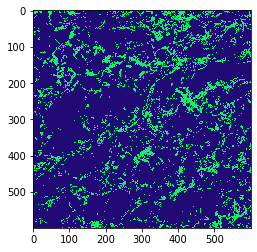

In [15]:
mat2plot(train.aft[0].data["Phase"])

In [8]:
BATCH_SIZE=16
train_loader=torch.utils.data.DataLoader(train,batch_size=BATCH_SIZE,shuffle=True,num_workers=0)
test_loader=torch.utils.data.DataLoader(test,batch_size=BATCH_SIZE,shuffle=True,num_workers=0)


In [10]:
train[0]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


(tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          ...,
          [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          [ 1.0000e+00,  0.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00]],
 
         [[ 1.5380e-01,  1.9650e-01,  2.2250e-01,  ...,  1.2490e-01,
            1.3710e-01,  2.0810e-01],
          [ 1.6810e-01,  2.4230e-01,  1.7460e-01,  ...,  2.1120e-01,
            1.3240e-01,  1.4300e-01],
          [ 1.5170e-01,  1.7930e-01,  2.7500e-01,  ...,  2.0070e-01,
            1.8480e-01,  1.6350e-01],
          ...,
    

In [23]:
# index=1
# X,Y,ind,ind_=test[index]
# h,w=50,50
# h0,w0=ind
# imgshow(test.im[index][h0:h0+h,w0:w0+w])
# h1,w1=ind_
# imgshow(test.im_[index][h1:h1+h,w1:w1+w])


In [61]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device="cpu"
model = UNet(n_classes=2,in_channels=15,depth=2,wf=4, padding=False, batch_norm=1,up_mode='upconv').to(device)
optim = torch.optim.Adam(model.parameters(),lr=1e-4)
epochs = 3

In [63]:
for ep in range(epochs):
    model.train()
    for _, (X,Y,im,im_) in enumerate(train_loader):
        X = X.to(device); # [N, 1, H, W]
        Y = Y.to(device); # [N, H, W] with class indices (0, 1)
        prediction = model(X)  # [N, 2, H, W]
        loss = F.cross_entropy(prediction, Y)
        print(loss.item(),np.mean((torch.max(prediction,1)[1]==Y).cpu().numpy()))
        break
    optim.zero_grad()
    loss.backward()
    optim.step()
    model.eval()
    for _, (X,Y,im,im_) in enumerate(test_loader):
        X = X.to(device); # [N, 1, H, W]
        Y = Y.to(device); # [N, H, W] with class indices (0, 1)
        prediction = model(X)  # [N, 2, H, W]
        loss = F.cross_entropy(prediction, Y)
        print(loss.item(),np.mean((torch.max(prediction,1)[1]==Y).cpu().numpy()))
        break
    

KeyboardInterrupt: 

In [27]:
# plt.imshow(Y[0,:,:].detach().numpy(),cmap="gray")

torch.Size([16, 66, 66, 15])

In [38]:
for _, (X,Y,ind,ind_) in enumerate(test_loader):
    X = X.to(device); # [N, 1, H, W]
    Y = Y.to(device); # [N, H, W] with class indices (0, 1)
    prediction = model(X)  # [N, 2, H, W]
    loss = F.cross_entropy(prediction, Y)
    print(loss.item(),np.mean((torch.max(prediction,1)[1]==Y).cpu().numpy()))
    break

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


0.6248690485954285 0.849825


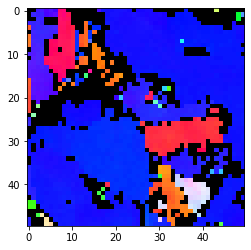

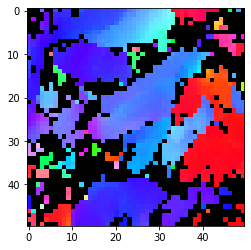

In [51]:
index=1
mode=0
h,w=50,50
h0,w0=ind[index][0],ind[index][1]
imgshow(test.im[mode][h0:h0+h,w0:w0+w])
h1,w1=ind_[index][0],ind_[index][1]
imgshow(test.im_[mode][h1:h1+h,w1:w1+w])


0


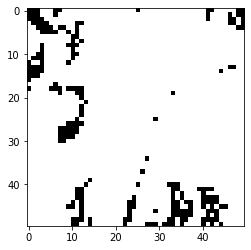

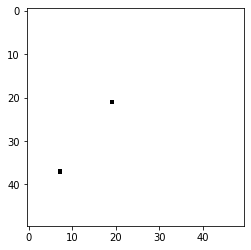

1


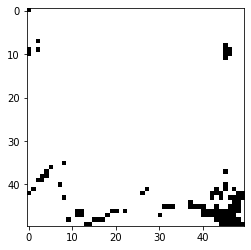

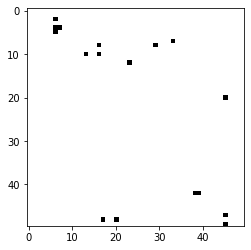

2


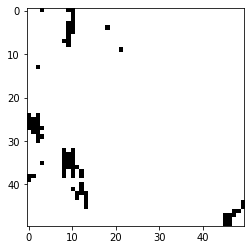

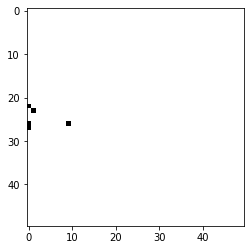

3


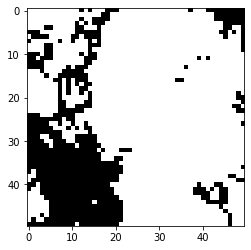

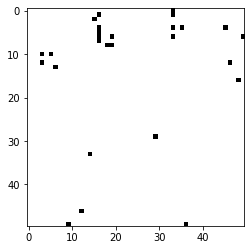

4


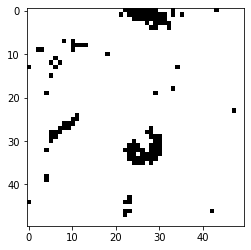

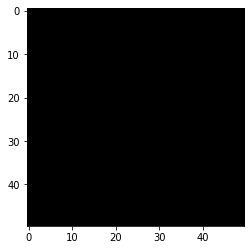

5


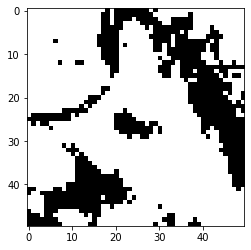

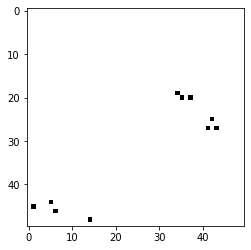

6


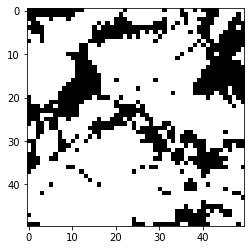

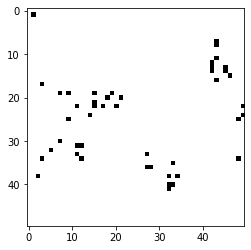

7


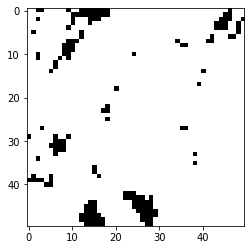

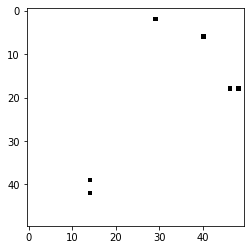

8


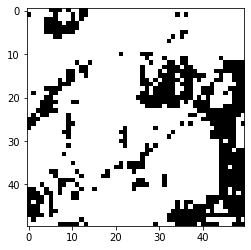

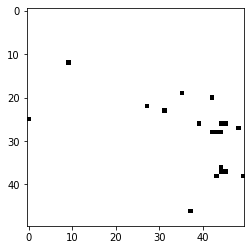

9


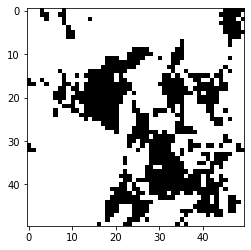

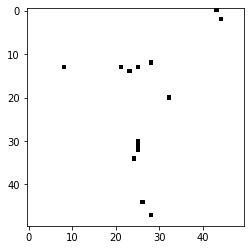

In [60]:
for i in range(10):
    print(i)
    plt.imshow(Y[i,:,:].detach().numpy(),cmap="gray")
    plt.show()
    plt.imshow(torch.max(prediction,1)[1][i].detach().numpy(),cmap="gray")
    plt.show()

torch.Size([16, 50, 50])